In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

In [30]:
data_water=parse.parse('cloudrm2_water.dat')
data_clear=parse.parse('cloudrm2_clear.dat')
data_ice=parse.parse('cloudrm2_ice.dat')
data_mixed=parse.parse('cloudrm2_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=data_all.drop(columns=['Cloud_B01','Clear_B01'])
data_all=hf.dumb_down_surface(data_all)
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13','Sun_Zenith_Angle']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

In [31]:
main_filepath='pytorch_models/optuna_optimum'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)
y_true=y_test.to_numpy()
#y_true=df.iloc[y_test.index][clear_labels]

In [32]:
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [33]:
np.shape(X_test.to_numpy())

(20000, 16)

In [34]:
for i,model in enumerate(models):
    if i==0:
        pred_y=model.predict(X_test.to_numpy())
    else:   
        pred_y=pred_y+model.predict(X_test.to_numpy())
pred_y=pred_y/len(models)

#X_tmp=np.zeros((np.shape(X_test.to_numpy())[0],np.shape(X_test.to_numpy())[1],9))
#for i in range(np.shape(X_tmp)[2]):
#    X_tmp[:,:,i]=X_test.to_numpy()

#pred_y=X_tmp-pred_y #For cloud estimation

In [35]:
tmp=models[0]
loss=tmp.train_loss.data.cpu().numpy()
np.argmin(loss[loss>0])

375

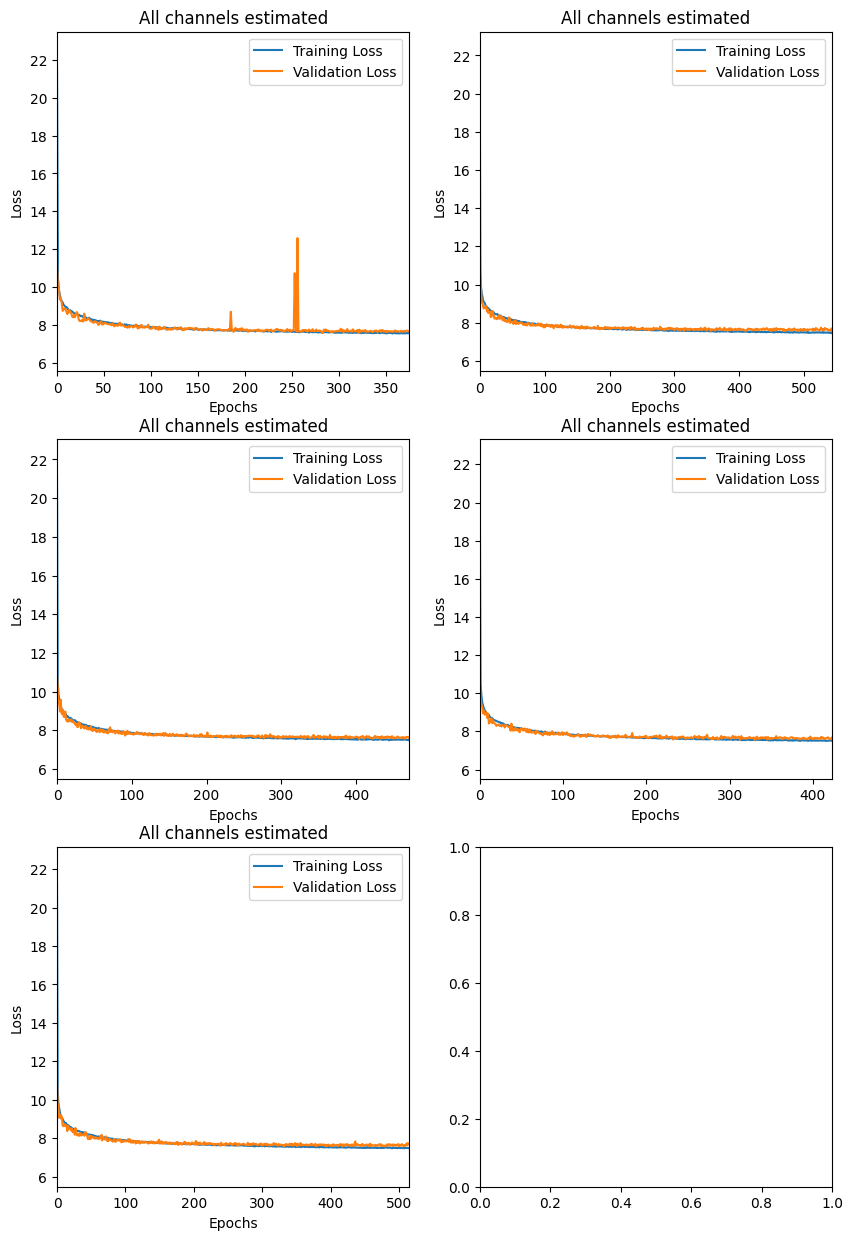

In [36]:
nmodels=len(models)
ncols=2
nrows=int(np.ceil(nmodels/ncols))
plt.rcParams["figure.figsize"] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):
    if i<nmodels:
        train_loss=models[i].train_loss.data.cpu().numpy()
        train_loss_l0=train_loss[train_loss>0]
        val_loss=models[i].val_loss.data.cpu().numpy()
        val_loss_l0=val_loss[val_loss>0]
        ax.plot(train_loss)
        ax.plot(val_loss)
        ax.set_title("All channels estimated")
        ax.legend(['Training Loss','Validation Loss'])
        ax.set_xlim(0,np.max([np.argmin(train_loss_l0),np.argmin(val_loss_l0)]))
        ax.set_ylim(np.min(train_loss_l0)-2,np.max(train_loss_l0)+2)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")

In [37]:
np.shape(pred_y)

(20000, 12, 9)

In [38]:
np.shape(y_test)

(20000, 12)

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/filip/SEEX30_Cloud_Fog/SEEX30_Cloud_Fog/Cloud_rm/functions/plot_metrics_one.py:194: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[f_i].errorbar(x=np.linspace(0,len(y_pred_sort_samp[i][:,index_median]),len(y_pred_sort_samp[i][:,index_median]))


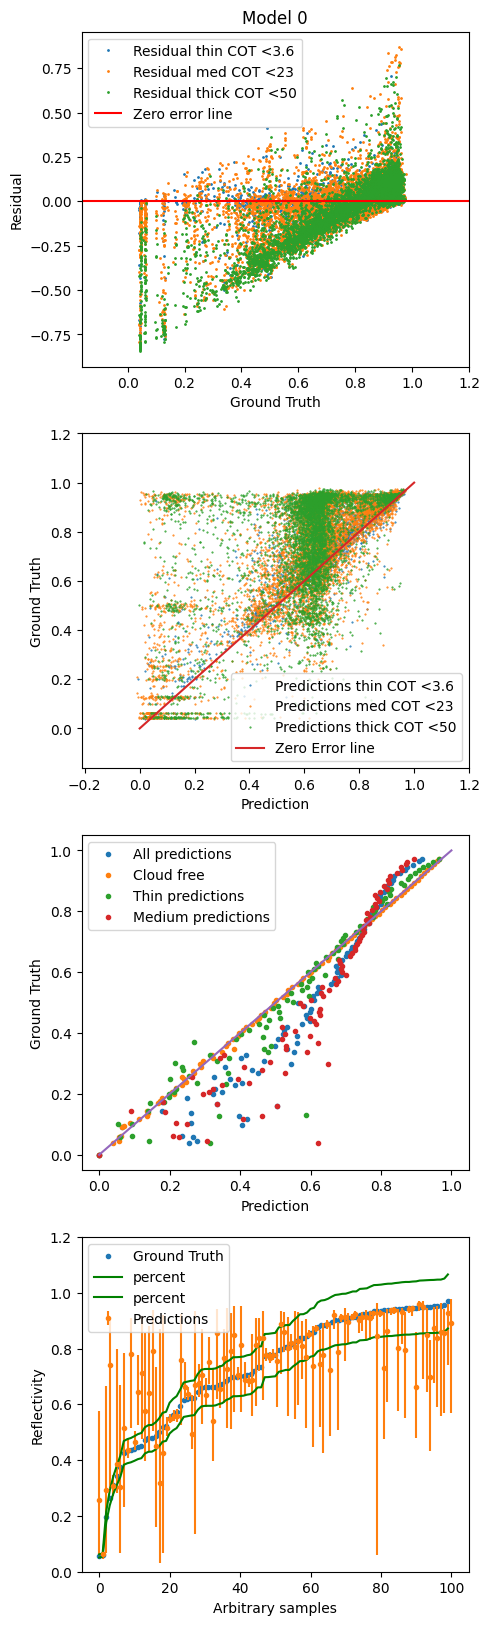

In [39]:
plt.rcParams["figure.figsize"] = [5, 5*4]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics_one([models],
                                                                [X_test],
                                                                [y_test],
                                                                [pred_y],
                                                                df,
                                                                samples=100,
                                                                is_ensemble=True,
                                                                index_median=4)

In [40]:
#Indices for different COT
cot_thin=3.6
cot_med=23
cot_thick=50

#Get indexes for optical thin, med and thick
test_indices=X_test.index
df_tmp=df.iloc[test_indices]

#Reset index for future indexing
df_tmp=df_tmp.reset_index()
df_tmp=df_tmp.drop(columns=["index"])

indices_zero=df_tmp[df_tmp['COT']==0].index
indices_thin=df_tmp[(df_tmp['COT']<=cot_thin)&df_tmp['COT']>0].index
indices_med=df_tmp[(df_tmp['COT']>cot_thin)&(df_tmp['COT']<=cot_med)].index
indices_thick=df_tmp[df_tmp['COT']>cot_med].index

/tmp/ipykernel_36077/3793224487.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[0,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_36077/3793224487.py:56: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[0,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_36077/3793224487.py:80: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[1,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_36077/3793224487.py:104: UserWarning: marker is r

Text(0.5, 0.98, 'Samples of reflectivity prediction channel 11, with uncertainty and truth value')

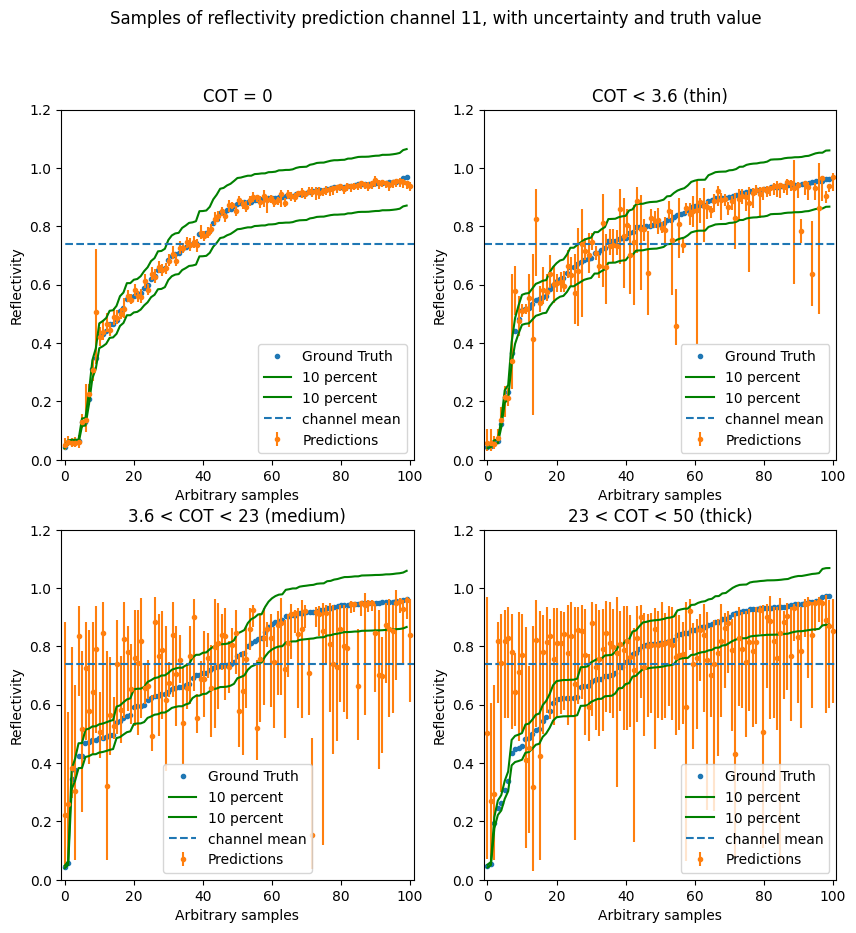

In [41]:

plt.rcParams["figure.figsize"] = [10, 10]
fig, axs=plt.subplots(ncols=2,nrows=2)
samples=100
index_median=4
#sort=np.argsort(y_true)
#y_true_sort=y_true[sort]
#y_pred_sort=pred_y[sort]
y_true_11=y_true[:,10]
pred_y_11=pred_y[:,10,:]

y_true_11_mean=np.mean(y_true_11)

y_true_11_zero=y_true_11[indices_zero]
y_true_11_thin=y_true_11[indices_thin]
y_true_11_med=y_true_11[indices_med]
y_true_11_thick=y_true_11[indices_thick]

pred_y_11_zero=pred_y_11[indices_zero]
pred_y_11_thin=pred_y_11[indices_thin]
pred_y_11_med=pred_y_11[indices_med]
pred_y_11_thick=pred_y_11[indices_thick]


## ZERO COT ##
y_samp=y_true_11_zero[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_zero[:samples][sort]
# Plot the values
axs[0,0].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[0,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[0,0].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='10 percent')
axs[0,0].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='10 percent')
axs[0,0].hlines(y_true_11_mean,xmin=-100,xmax=samples+20,linestyles='dashed',label='channel mean')
axs[0,0].set_xlabel("Arbitrary samples")
axs[0,0].set_ylabel("Reflectivity")
axs[0,0].set_ylim((0,1.2))
axs[0,0].set_xlim((-1,samples+1))
axs[0,0].legend()
axs[0,0].set_title("COT = 0")



y_samp=y_true_11_thin[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_thin[:samples][sort]
# Plot the values
axs[0,1].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[0,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[0,1].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='10 percent')
axs[0,1].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='10 percent')
axs[0,1].hlines(y_true_11_mean,xmin=-100,xmax=samples+20,linestyles='dashed',label='channel mean')
axs[0,1].set_xlabel("Arbitrary samples")
axs[0,1].set_ylabel("Reflectivity")
axs[0,1].set_ylim((0,1.2))
axs[0,1].set_xlim((-1,samples+1))
axs[0,1].legend()
axs[0,1].set_title("COT < 3.6 (thin)")


y_samp=y_true_11_med[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_med[:samples][sort]
# Plot the values
axs[1,0].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[1,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[1,0].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='10 percent')
axs[1,0].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='10 percent')
axs[1,0].hlines(y_true_11_mean,xmin=-100,xmax=samples+20,linestyles='dashed',label='channel mean')
axs[1,0].set_xlabel("Arbitrary samples")
axs[1,0].set_ylabel("Reflectivity")
axs[1,0].set_ylim((0,1.2))
axs[1,0].set_xlim((-1,samples+1))
axs[1,0].legend()
axs[1,0].set_title("3.6 < COT < 23 (medium)")


y_samp=y_true_11_thick[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_thick[:samples][sort]
# Plot the values
axs[1,1].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[1,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[1,1].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='10 percent')
axs[1,1].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='10 percent')
axs[1,1].hlines(y_true_11_mean,xmin=-100,xmax=samples+20,linestyles='dashed',label='channel mean')
axs[1,1].set_xlabel("Arbitrary samples")
axs[1,1].set_ylabel("Reflectivity")
axs[1,1].set_ylim((0,1.2))
axs[1,1].set_xlim((-1,samples+1))
axs[1,1].legend()
axs[1,1].set_title("23 < COT < 50 (thick)")

fig.suptitle("Samples of reflectivity prediction channel 11, with uncertainty and truth value")

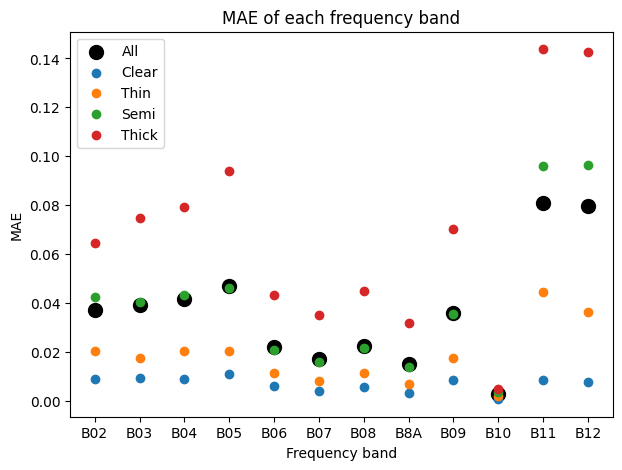

In [42]:
testindices=y_test.index
COTs=np.array(df['COT'].iloc[testindices])

#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = pred_y[(COTs==0),:,:]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<3.6),:]
thin_pred = pred_y[(COTs>0) & (COTs<3.6),:,:]
semi_true = y_test.to_numpy()[(COTs>=3.6) & (COTs<23),:]
semi_pred = pred_y[(COTs>=3.6) & (COTs<23),:,:]
thick_true = y_test.to_numpy()[(COTs>=23),:]
thick_pred = pred_y[(COTs>=23),:,:]


#Find and print MAE of each band
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-pred_y[:,:,index_median]),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred[:,:,index_median]),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred[:,:,index_median]),axis=0)
MAE_col_semi = np.mean(np.abs(semi_true-semi_pred[:,:,index_median]),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred[:,:,index_median]),axis=0)

x=np.arange(np.size(MAE_col_tot))
plt.rcParams["figure.figsize"] = [7, 5]
plt.figure()
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_clear)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_semi)
plt.scatter(x,MAE_col_thick)
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['All','Clear','Thin','Semi','Thick'])
plt.show()

In [43]:
np.shape(pred_y_11)

(20000, 9)

In [44]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))

Text(0, 0.5, 'Ground Truth')

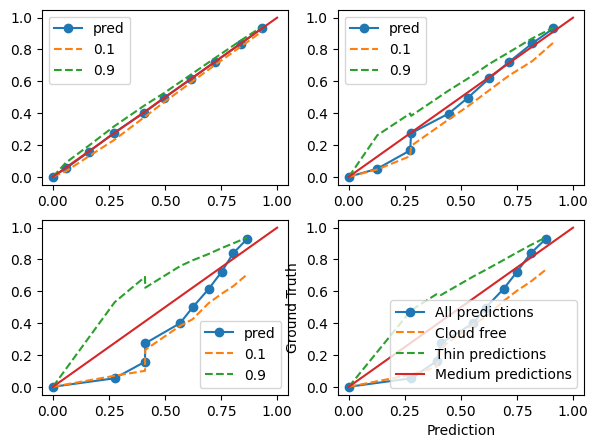

In [45]:


band=10
## Prediction v Ground Truth ##
y_true_11=y_test.to_numpy()[:,band]
pred_y_11=pred_y[:,band]
bins=np.linspace(0,1,10)

freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))
unc_1=np.zeros(len(bins))
unc_9=np.zeros(len(bins))

freq_true_zero=np.zeros(len(bins))
freq_pred_zero=np.zeros(len(bins))
unc_1_zero=np.zeros(len(bins))
unc_9_zero=np.zeros(len(bins))

freq_true_thin=np.zeros(len(bins))
freq_pred_thin=np.zeros(len(bins))
unc_1_thin=np.zeros(len(bins))
unc_9_thin=np.zeros(len(bins))

freq_true_med=np.zeros(len(bins))
freq_pred_med=np.zeros(len(bins))
unc_1_med=np.zeros(len(bins))
unc_9_med=np.zeros(len(bins))

y_tmp_zero=clear_true[:,band]
y_tmp_thin=thin_true[:,band]
y_tmp_med=semi_true[:,band]

y_tmp_pred_zero=clear_pred[:,band]
y_tmp_pred_thin=thin_pred[:,band]
y_tmp_pred_med=semi_pred[:,band]

for j,edge in enumerate(bins):
    if j!=0:
        indices=(y_true_11>bins[j-1])&(y_true_11<=edge)
        ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
        ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
        ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

        mean_bin_true=np.mean(y_true_11[indices])
        mean_bin_pred=np.mean(pred_y_11[indices,index_median])

        mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
        mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z,index_median])

        mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
        mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t,index_median])

        mean_bin_true_med=np.mean(y_tmp_med[ind_m])
        mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m,index_median])
        
        freq_true[j]=mean_bin_true
        freq_pred[j]=mean_bin_pred
        unc_1[j]=np.mean(pred_y_11[indices,0])
        unc_9[j]=np.mean(pred_y_11[indices,-1])

        freq_true_zero[j]=mean_bin_true_zero
        freq_pred_zero[j]=mean_bin_pred_zero
        unc_1_zero[j]=np.mean(y_tmp_pred_zero[ind_z,0])
        unc_9_zero[j]=np.mean(y_tmp_pred_zero[ind_z,-1])

        freq_true_thin[j]=mean_bin_true_thin
        freq_pred_thin[j]=mean_bin_pred_thin
        unc_1_thin[j]=np.mean(y_tmp_pred_thin[ind_t,0])
        unc_9_thin[j]=np.mean(y_tmp_pred_thin[ind_t,-1])

        freq_true_med[j]=mean_bin_true_med
        freq_pred_med[j]=mean_bin_pred_med
        unc_1_med[j]=np.mean(y_tmp_pred_med[ind_m,0])
        unc_9_med[j]=np.mean(y_tmp_pred_med[ind_m,-1])



ncols=2
nrows=2
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

plt.rcParams["figure.figsize"] = [5*ncols, 5*nrows]

axs[0,0].plot(freq_pred_zero,freq_true_zero,'-o')
axs[0,0].plot(freq_pred_zero,unc_1_zero,'--')
axs[0,0].plot(freq_pred_zero,unc_9_zero,'--')
axs[0,0].legend(['pred','0.1','0.9'])

axs[0,1].plot(freq_pred_thin,freq_true_thin,'-o')
axs[0,1].plot(freq_pred_thin,unc_1_thin,'--')
axs[0,1].plot(freq_pred_thin,unc_9_thin,'--')
axs[0,1].legend(['pred','0.1','0.9'])

axs[1,0].plot(freq_pred_med,freq_true_med,'-o')
axs[1,0].plot(freq_pred_med,unc_1_med,'--')
axs[1,0].plot(freq_pred_med,unc_9_med,'--')
axs[1,0].legend(['pred','0.1','0.9'])

axs[1,1].plot(freq_pred,freq_true,'-o')
axs[1,1].plot(freq_pred,unc_1,'--')
axs[1,1].plot(freq_pred,unc_9,'--')
axs[1,1].legend(['pred','0.1','0.9'])
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
axs[0,0].plot(line,line)
axs[0,1].plot(line,line)
axs[1,0].plot(line,line)
axs[1,1].plot(line,line)
plt.legend(['All predictions','Cloud free','Thin predictions','Medium predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")

Text(0.5, 1.0, 'Ground truth over prediction, channel 11, different COT')

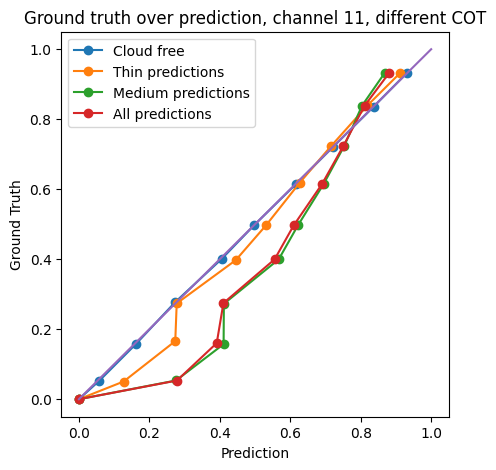

In [46]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(freq_pred_zero,freq_true_zero,'-o')
plt.plot(freq_pred_thin,freq_true_thin,'-o')
plt.plot(freq_pred_med,freq_true_med,'-o')
plt.plot(freq_pred,freq_true,'-o')

#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
plt.plot(line,line)

plt.legend(['Cloud free','Thin predictions','Medium predictions','All predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Ground truth over prediction, channel 11, different COT")

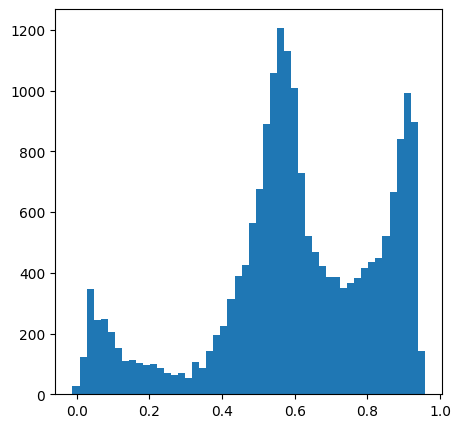

In [47]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.hist(pred_y_11[:,0],bins=50)
plt.show()

In [48]:
#np.mean(pred_y_7[:,4])

In [49]:
#plt.hist(pred_y_7[:,4],alpha=0.7)
#plt.hist(y_test['Clear_B05'],alpha=0.7)

In [50]:
MSE=[]
R2=[]
PSNR=[]
quantrates=[]
quantcross=[]

MSE.append(mean_squared_error(y_true,pred_y[:,:,index_median]))
R2.append(r2_score(y_true,pred_y[:,:,index_median]))
PSNR.append(calc_metrics.PSNR(y_true,pred_y[:,:,index_median]))
quantrates.append(calc_metrics.quant_rate(y_true,pred_y))
quantcross.append(calc_metrics.quant_cross(pred_y))

In [51]:

print("MSE: "+str(MSE[0]))
print(" ")
print("R2 score: "+str(R2[0]))
print(" ")

print("PSNR: "+str(PSNR[0]))
print(" ")
print("Quantrate: "+str(quantrates[0]))
print(" ")
print("Quantile crossing: "+str(quantcross[0]))

MSE: 0.0063144371759052105
 
R2 score: 0.8559464514050218
 
PSNR: 22.018270937069182
 
Quantrate: [0.0704     0.15467083 0.2464     0.35464583 0.47808333 0.60730417
 0.72675    0.8300125  0.9215875 ]
 
Quantile crossing: 0.0


In [52]:
test_indices=X_test.index
df_test=df.loc[test_indices]
df_test=df_test.reset_index()
df_test_clear=df_test[df_test['COT']==0]
df_test_thin=df_test[(df_test['COT']<=3.6) & (df_test['COT']>0)]
df_test_med=df_test[(df_test['COT']<=23) & (df_test['COT']>3.6)]
df_test_thick=df_test[(df_test['COT']<=50) & (df_test['COT']>23)]

In [53]:

MSE_cot_levels=[]
MSE_cot_levels.append(mean_squared_error(y_true,pred_y[:,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_clear.index],pred_y[df_test_clear.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_thin.index],pred_y[df_test_thin.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_med.index],pred_y[df_test_med.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_thick.index],pred_y[df_test_thick.index,:,4]))

In [54]:
print("MSE all test data: "+str(MSE_cot_levels[0]))
print("MSE clear test data: "+str(MSE_cot_levels[1]))
print("MSE thin COT <3.6 test data: "+str(MSE_cot_levels[2]))
print("MSE med COT <23 test data: "+str(MSE_cot_levels[3]))
print("MSE thick COT <50 test data: "+str(MSE_cot_levels[4]))

MSE all test data: 0.0063144371759052105
MSE clear test data: 0.00016549186423026066
MSE thin COT <3.6 test data: 0.001657957466528046
MSE med COT <23 test data: 0.005957341787630706
MSE thick COT <50 test data: 0.01466027432968342


## Check outliers in thin data

In [55]:
df_thin=df_tmp.iloc[indices_thin]
df_thin_X=df_thin[X_labels]


In [56]:
for i,model in enumerate(models):
    if i==0:
        pred_y_t=model.predict(df_thin_X.to_numpy())
    else:   
        pred_y_t=pred_y_t+model.predict(df_thin_X.to_numpy())
pred_y_t=pred_y_t/len(models)
pred_y_t_median=pred_y_t[:,:,index_median]


ValueError: operands could not be broadcast together with shapes (2211,13) (1,16) 

In [ ]:
#Get outlier predictions
channel=10
outlier_ind=np.abs(df_thin[y_labels].to_numpy()[:,channel]-pred_y_t_median[:,channel])>0.1*df_thin[y_labels].to_numpy()[:,channel]
outlier_ind

array([False, False, False, ...,  True, False, False])

In [ ]:
# Get outliers in dataframe
df_thin_out=df_thin[outlier_ind]


In [ ]:
df_thin_out

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,...,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor,Surface_Desc,Surface_Desc_Dumb
100,0.33658,0.61057,0.49556,0.94770,0.97178,0.98789,0.94076,1.00141,0.38555,0.00910,...,1.29,55.32,15.25,0.637,11,959,0.122,0.70,nonphotosyntheticvegetation-flowers-calocedrus,nonphotosyntheticvegetation
133,0.31210,0.31042,0.23616,0.40681,0.54023,0.58085,0.51052,0.60271,0.07275,0.00228,...,10.79,82.74,22.38,0.981,2,7837,0.128,4.98,vegetation-shrub-arctostaphylos,vegetation
184,0.33973,0.33602,0.27947,0.45438,0.67048,0.72088,0.62564,0.75300,0.03989,0.00098,...,11.56,82.10,56.38,0.866,6,6907,0.127,2.05,vegetation-tree-pinus,vegetation
268,0.40810,0.40365,0.37248,0.42834,0.84850,0.91641,0.78696,0.95476,0.04707,0.00033,...,12.08,59.37,140.06,3.483,6,7598,0.129,4.96,vegetation-shrub-ceanothus,vegetation
274,0.99395,0.93517,0.98674,1.00448,1.01532,1.02035,1.01082,1.02652,0.75118,0.05853,...,0.57,45.15,173.59,0.369,3,1720,0.125,0.15,water-snow-coarsegranular,water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19792,0.37872,0.46903,0.32962,0.57735,0.92048,0.97900,0.85385,1.01612,0.18819,0.00323,...,10.12,45.23,141.76,3.084,6,5662,0.128,2.98,vegetation-tree-pinus,vegetation
19849,0.40758,0.37513,0.37427,0.33546,0.35413,0.37481,0.32665,0.37742,0.10041,0.00392,...,8.75,44.53,43.44,2.252,4,9102,0.130,7.37,rock-sedimentary-shale,rock
19938,0.25385,0.25836,0.46539,0.53749,0.60499,0.65500,0.63672,0.67224,0.24723,0.00184,...,9.73,83.02,101.36,0.510,2,4197,0.123,0.30,soil-alfisol-paleustalf,soil
19944,0.54941,0.53255,0.57124,0.57632,0.58836,0.59858,0.58452,0.60836,0.31431,0.01073,...,5.88,48.37,157.56,3.462,1,545,0.124,0.40,rock-igneous-intermediate,rock


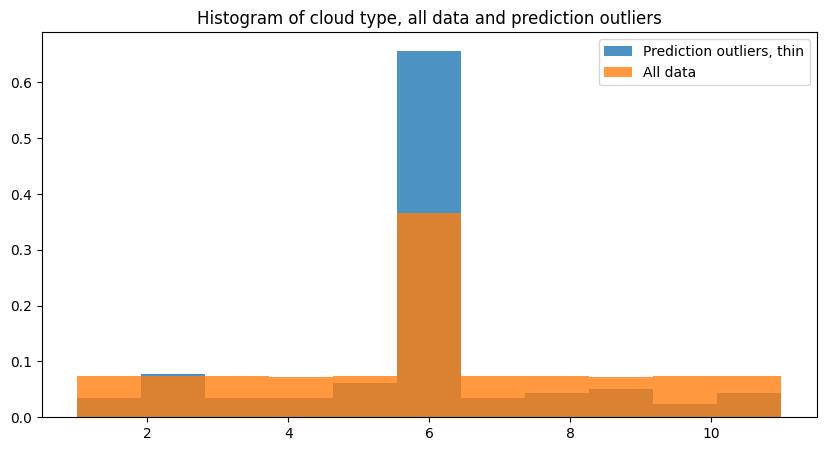

In [ ]:
plt.hist(df_thin_out.Cloud_Type,density=True,alpha=0.8,bins=11)
plt.hist(df[df['COT']>0].Cloud_Type,density=True,alpha=0.8,bins=11)
plt.title("Histogram of cloud type, all data and prediction outliers")
plt.legend(["Prediction outliers, thin","All data"])
plt.show()

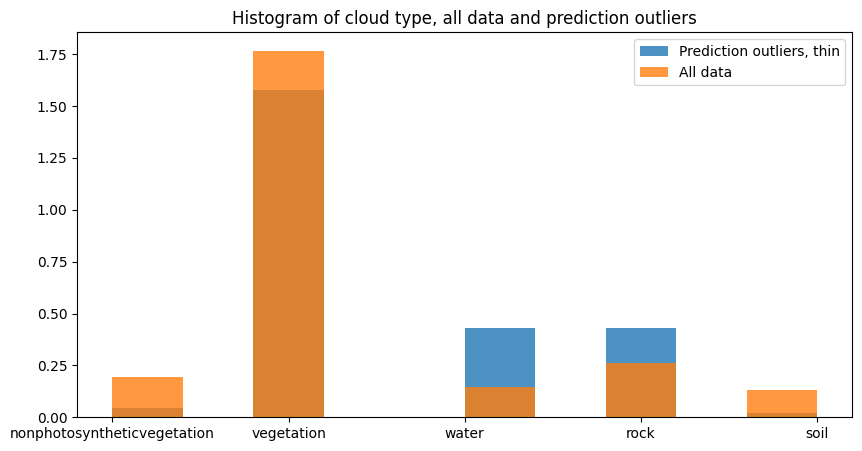

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_thin_out.Surface_Desc_Dumb,density=True,alpha=0.8)
plt.hist(df.Surface_Desc_Dumb,density=True,alpha=0.8)
plt.title("Histogram of surface description, all data and prediction outliers")
plt.legend(["Prediction outliers, thin","All data"])
plt.show()

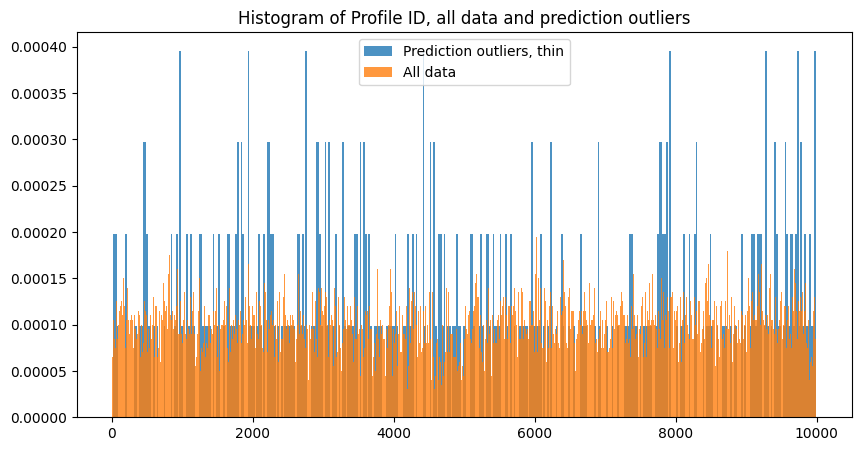

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_thin_out.Profile_ID,density=True,alpha=0.8,bins=len(df_thin_out.Profile_ID.unique()))
plt.hist(df.Profile_ID,density=True,alpha=0.8,bins=len(df.Profile_ID.unique()))
plt.title("Histogram of Profile ID, all data and prediction outliers")
plt.legend(["Prediction outliers, thin","All data"])
plt.show()

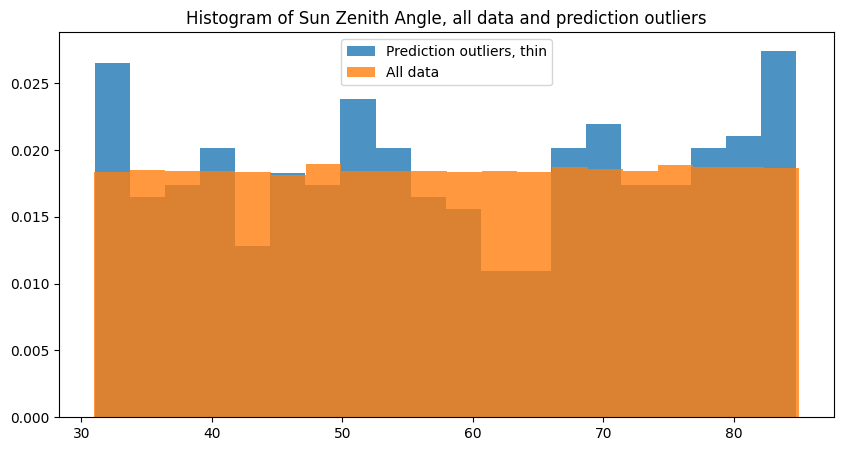

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_thin_out.Sun_Zenith_Angle,density=True,alpha=0.8,bins=20)
plt.hist(df.Sun_Zenith_Angle,density=True,alpha=0.8,bins=20)
plt.title("Histogram of Sun Zenith Angle, all data and prediction outliers")
plt.legend(["Prediction outliers, thin","All data"])
plt.show()

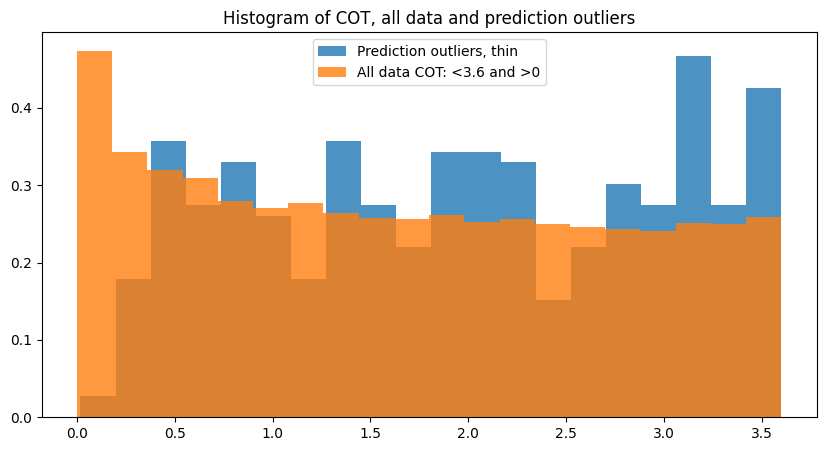

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_thin_out.COT,density=True,alpha=0.8,bins=20)
plt.hist(df[(df['COT']<3.6)&(df['COT']>0)].COT,density=True,alpha=0.8,bins=20)
plt.title("Histogram of COT, all data and prediction outliers")
plt.legend(["Prediction outliers, thin","All data COT: <3.6 and >0"])
plt.show()

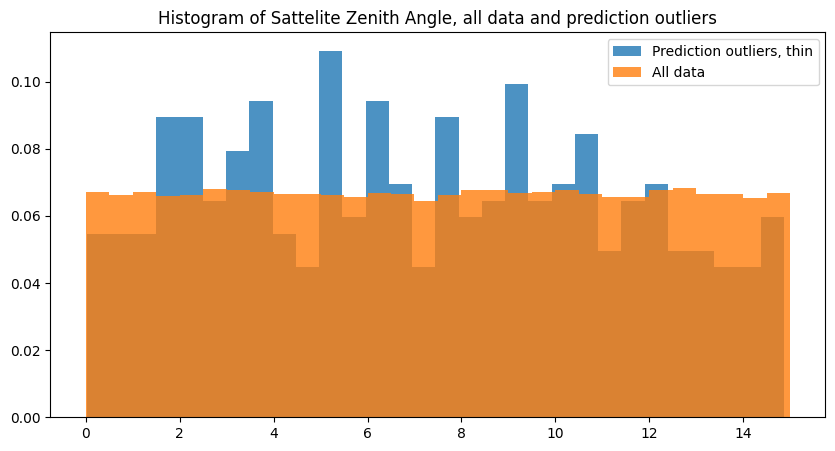

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_thin_out.Sat_Zenith_Angle,density=True,alpha=0.8,bins=30)
plt.hist(df.Sat_Zenith_Angle,density=True,alpha=0.8,bins=30)
plt.title("Histogram of Sattelite Zenith Angle, all data and prediction outliers")
plt.legend(["Prediction outliers, thin","All data"])
plt.show()

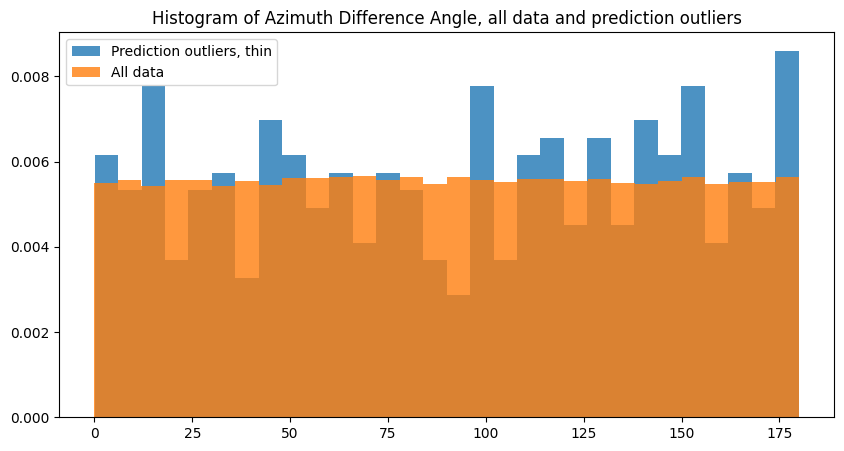

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_thin_out.Azimuth_Diff_Angle,density=True,alpha=0.8,bins=30)
plt.hist(df.Azimuth_Diff_Angle,density=True,alpha=0.8,bins=30)
plt.title("Histogram of Azimuth Difference Angle, all data and prediction outliers")
plt.legend(["Prediction outliers, thin","All data"])
plt.show()

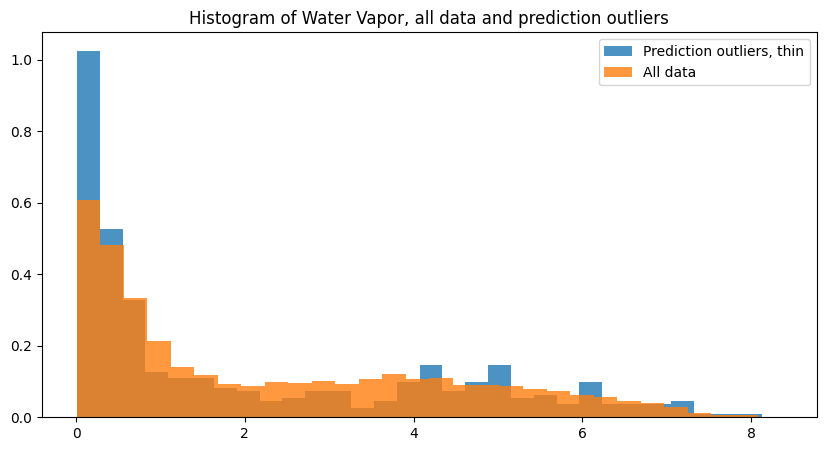

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_thin_out.Water_Vapor,density=True,alpha=0.8,bins=30)
plt.hist(df.Water_Vapor,density=True,alpha=0.8,bins=30)
plt.title("Histogram of Water Vapor, all data and prediction outliers")
plt.legend(["Prediction outliers, thin","All data"])
plt.show()